In [0]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import glob
from PIL import Image
import torch
from torch import nn, optim

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!tar -xvf "../content/gdrive/My Drive/datasets/coco.tar"

In [0]:
root_path = "coco"

# create data_loader for images
class SaliencyDataset(Dataset):
    def __init__(self):
        self.heatmap_path_list = glob.glob(f"{root_path}/heatmaps/*.jpg")
        
    def __getitem__(self, index):
        heatmap_path = self.heatmap_path_list[index]
        image_path = f"{root_path}/images/"+heatmap_path.split('/')[-1]
                
        heatmap = Image.open(heatmap_path)
        image = Image.open(image_path).convert('RGB')
        
        to_tensot = transforms.ToTensor()
        resize_240 = transforms.Resize(240)
        resize_30 = transforms.Resize(30)
        
        return to_tensot(resize_30(heatmap)), to_tensot(resize_240(image))

    def __len__(self):
        return len(self.heatmap_path_list)

In [0]:
batch_size = 4

dataset = SaliencyDataset()
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

torch.Size([4, 1, 30, 40]) torch.Size([4, 3, 240, 320])


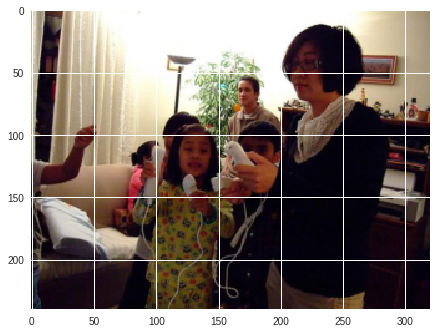

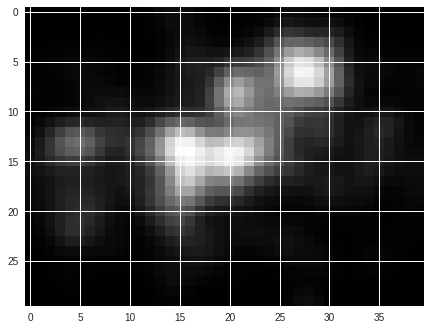

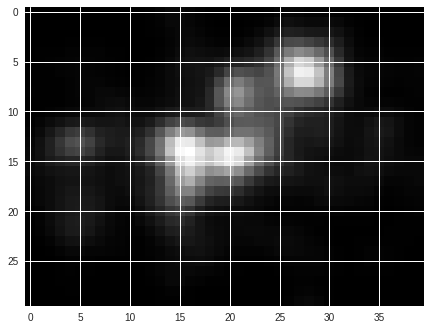

In [117]:
heatmaps, images = next(iter(loader))

print(heatmaps.shape, images.shape)

plt.imshow(images[0].permute(1, 2, 0))
plt.show()

heatmap = heatmaps[0].view(30, 40)
plt.imshow(heatmap, cmap='Greys_r')
plt.show()

heatmap = torch.softmax(heatmaps[0].view(-1), dim=0).view(30, 40)
plt.imshow(heatmap, cmap='Greys_r')
plt.show()

In [0]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        
        self.resblock = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(channels, affine=True),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(channels, affine=True),
        )
        
    def forward(self, x):
        out = self.resblock(x)
        return out + x

class MicroResNet(nn.Module):
    def __init__(self):
        super(MicroResNet, self).__init__()
        
        self.downsampler = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=9, padding=4),
            nn.InstanceNorm2d(8, affine=True),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2),
            nn.InstanceNorm2d(16, affine=True),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
        )
        
        self.residual = nn.Sequential(
            ResBlock(64),
            ResBlock(64)
        )
        
        self.segmentator = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.InstanceNorm2d(16, affine=True),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=9, padding=4),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.downsampler(x)
        for i in range(2): # recursively use the same simple block 2 times
          out = self.residual(out)
        out = self.segmentator(out)
        return out

In [0]:
model = MicroResNet()

In [120]:
heatmaps, images = next(iter(loader))

pred = model(images)
print(pred.shape, heatmaps.shape)

torch.Size([4, 1, 30, 40]) torch.Size([4, 1, 30, 40])


In [144]:
epochs = 4

optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.MSELoss()

model.train()
model.cuda()
for e in range(1, epochs+1):
    total_loss = 0
    batch = 0
    for heatmaps, images in loader:
        heatmaps, images = heatmaps.cuda(), images.cuda()
        batch += 1
        optimizer.zero_grad()
        batch_size = images.size(0)

        pred = model.forward(images)
        
        pred_softmax = torch.softmax(pred.view(batch_size, -1), dim=1)
        heatmaps_softmax = torch.softmax(heatmaps.view(batch_size, -1), dim=1)
        loss = criterion(pred, heatmaps)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch % 100 == 0:
          print(f"EPOCH {e} ({batch}/{len(loader)}) - loss {total_loss/batch:.4f}")
    
    print(f"EPOCH {e} ({len(loader)}/{len(loader)}) - loss {total_loss/batch:.4f}")

EPOCH 1 (100/2016) - loss 0.0077
EPOCH 1 (200/2016) - loss 0.0076
EPOCH 1 (300/2016) - loss 0.0074
EPOCH 1 (400/2016) - loss 0.0075
EPOCH 1 (500/2016) - loss 0.0074
EPOCH 1 (600/2016) - loss 0.0074
EPOCH 1 (700/2016) - loss 0.0073
EPOCH 1 (800/2016) - loss 0.0073
EPOCH 1 (900/2016) - loss 0.0073
EPOCH 1 (1000/2016) - loss 0.0073
EPOCH 1 (1100/2016) - loss 0.0073
EPOCH 1 (1200/2016) - loss 0.0073
EPOCH 1 (1300/2016) - loss 0.0073
EPOCH 1 (1400/2016) - loss 0.0073
EPOCH 1 (1500/2016) - loss 0.0073
EPOCH 1 (1600/2016) - loss 0.0073
EPOCH 1 (1700/2016) - loss 0.0073
EPOCH 1 (1800/2016) - loss 0.0073
EPOCH 1 (1900/2016) - loss 0.0072
EPOCH 1 (2000/2016) - loss 0.0072
EPOCH 1 (2016/2016) - loss 0.0072
EPOCH 2 (100/2016) - loss 0.0072
EPOCH 2 (200/2016) - loss 0.0074
EPOCH 2 (300/2016) - loss 0.0073
EPOCH 2 (400/2016) - loss 0.0072
EPOCH 2 (500/2016) - loss 0.0071
EPOCH 2 (600/2016) - loss 0.0071
EPOCH 2 (700/2016) - loss 0.0072
EPOCH 2 (800/2016) - loss 0.0071
EPOCH 2 (900/2016) - loss 0.007

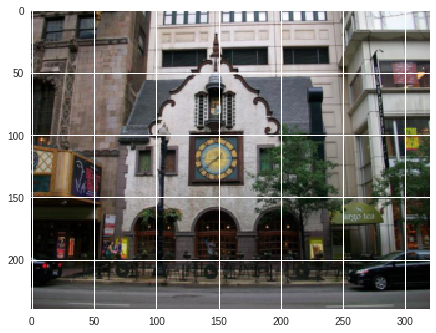

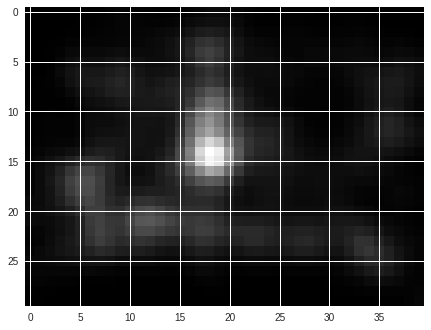

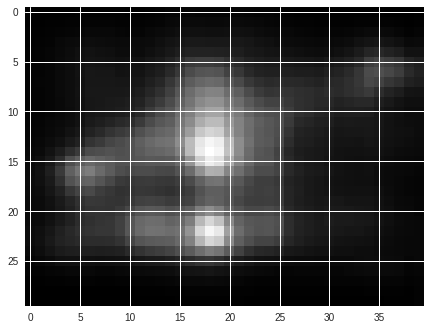

CENTER tensor(19.2517) tensor(14.5346)


In [147]:
with torch.no_grad():
    model.eval()
    model.cuda()
    heatmaps, images = next(iter(loader))

    preds = model(images.cuda()).cpu()

    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()

    heatmap = torch.softmax(heatmaps[0].view(-1), dim=0).view(30, 40) # heatmaps[0].view(30, 40)
    plt.imshow(heatmap, cmap='Greys_r')
    plt.show()

    temperature = 0.5
    tempered_pred = torch.log(torch.softmax(preds[0].view(-1), dim=0)) / temperature
    tempered_pred = torch.exp(tempered_pred) / torch.sum(torch.exp(tempered_pred))
    
    pred = tempered_pred.view(30, 40) # preds[0].view(30, 40)
    plt.imshow(pred, cmap='Greys_r')
    plt.show()
    
    center_x, center_y = 0, 0
    for i in range(pred.size(0)):
      for j in range(pred.size(1)):
        center_x += j * pred[i, j]
        center_y += i * pred[i, j]
    
    print("CENTER", center_x, center_y)

In [0]:
model.cpu()
torch.save(model.state_dict(), 'gdrive/My Drive/Colab Notebooks/saliency_model_v3.pt')

In [0]:
## VALIDATE MODEL

# create data_loader for images
class TestDataset(Dataset):
    def __init__(self):
        self.image_path_list = glob.glob(f"gdrive/My Drive/datasets/test_images/*.jpg")
        
    def __getitem__(self, index):
        image_path = self.image_path_list[index]
                
        image = Image.open(image_path).convert('RGB')
        
        to_tensot = transforms.ToTensor()
        resize_240 = transforms.Resize(240)
        
        return to_tensot(resize_240(image))

    def __len__(self):
        return len(self.image_path_list)
      
dataset_test = TestDataset()
loader_test = DataLoader(dataset_test, batch_size=1)

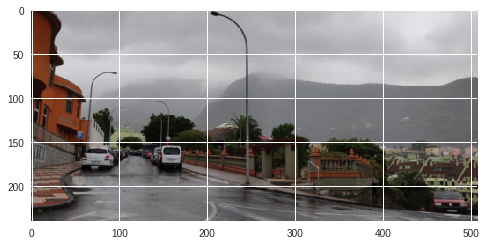

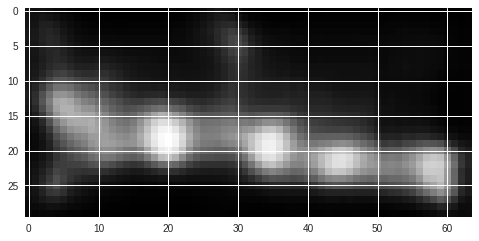

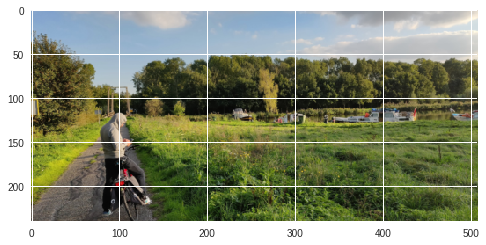

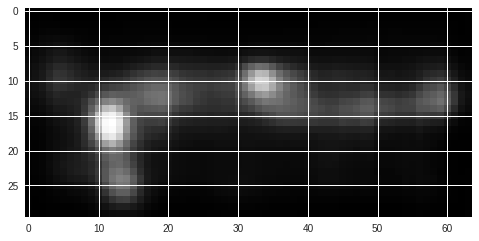

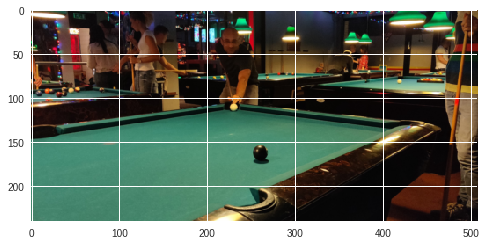

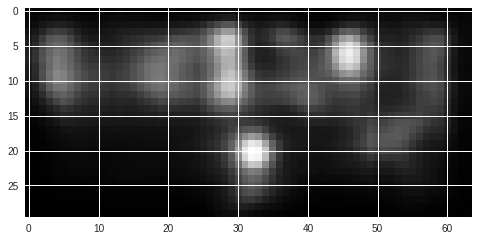

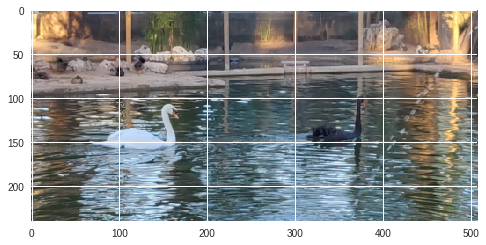

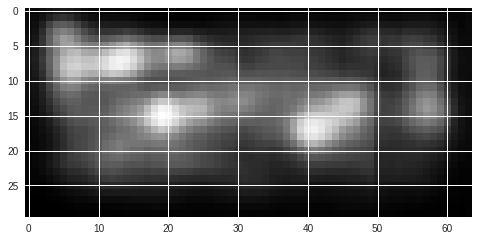

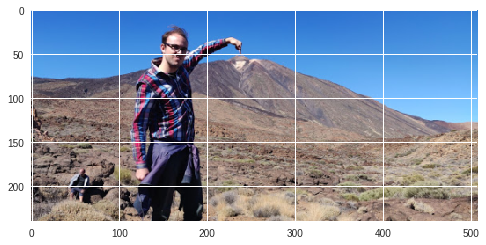

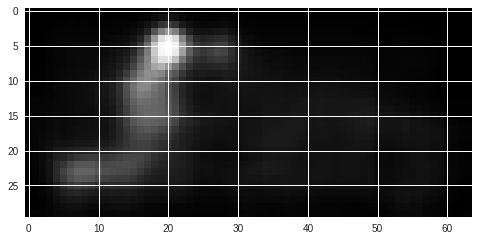

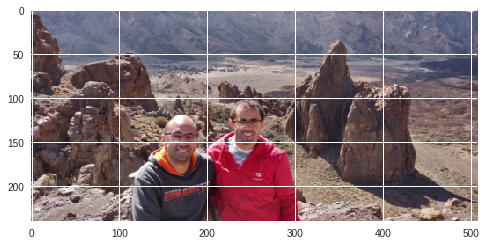

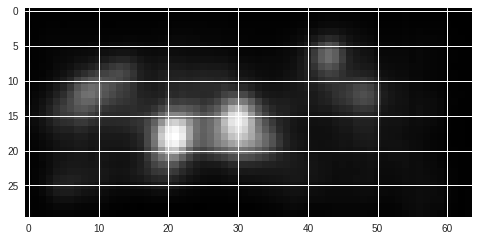

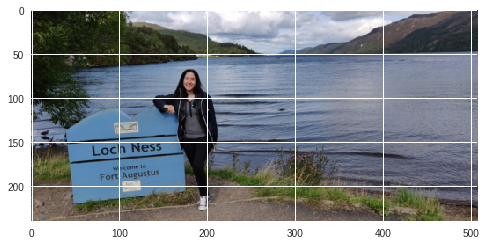

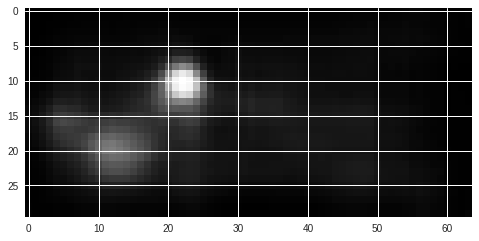

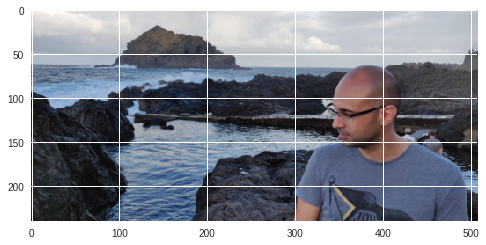

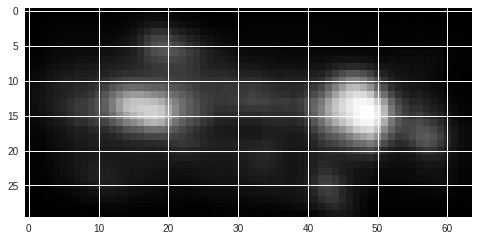

In [156]:
with torch.no_grad():
    model.eval()
    model.cuda()
    
    for images in loader_test:
      preds = model(images.cuda()).cpu()
      heatmap_h = preds.size(2)
      heatmap_w = preds.size(3)

      plt.imshow(images[0].permute(1, 2, 0))
      plt.show()
      
      temperature = 3
      tempered_pred = torch.log(torch.softmax(preds[0].view(-1), dim=0)) / temperature
      tempered_pred = torch.exp(tempered_pred) / torch.sum(torch.exp(tempered_pred))

      pred = tempered_pred.view(heatmap_h, heatmap_w)
      plt.imshow(pred, cmap='Greys_r')
      plt.show()